In [1]:
from juliacall import Main as jl
jl.seval("""
         import Pkg
         ENV["JULIA_SSL_CA_ROOTS_PATH"]=""
         ENV["JULIA_PKG_USE_CLI_GIT"]=true
         Pkg.add(url=\"https://github.com/MPF-Optimization-Laboratory/KLLS.jl.git\")
         """)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


    Updating git-repo `https://github.com/MPF-Optimization-Laboratory/KLLS.jl.git`
   Resolving package versions...
  No Changes to `C:\Users\mking\.julia\environments\pyjuliapkg\Project.toml`
  No Changes to `C:\Users\mking\.julia\environments\pyjuliapkg\Manifest.toml`


In [2]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np
import random as rd

# For MNIST data download
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import mnist_vae.vae as vae
plt.style.use('dark_background')
def to_im(x):
    return x.cpu().detach().numpy().reshape((28, 28))

%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
path = Path()
data_dir = path

test_root = os.path.join(data_dir, "data")

# Importing above, no need to re-run

In [3]:
jl.seval("""
         using KLLS
         solve = KLLS.solve!
         rescale = KLLS.scale!
         maximize = KLLS.maximize!
         regularize = KLLS.regularize!
         dObj = KLLS.dObj!
         dGrad = KLLS.dGrad!
         """);

In [4]:

net = vae.VAE()
net.load_state_dict(torch.load('mnist_vae/weights/vae_epoch_25.pth'))


<All keys matched successfully>

In [110]:
#{ Dataset
#test_data = datasets.MNIST(
#    root="data",
##   download=True,
#    transform=ToTensor()
# )
#dataloader = torch.utils.data.DataLoader(test_data, batch_size=1,
#                                             shuffle=False)

# commented out for now; but code for dcgan

In [112]:
#test_img = next(iter(dataloader))

#test_img_for_plot = test_img[0][0].detach().numpy()
#plt.imshow(np.reshape(test_img_for_plot,[28,28]), cmap='gray');

# as above

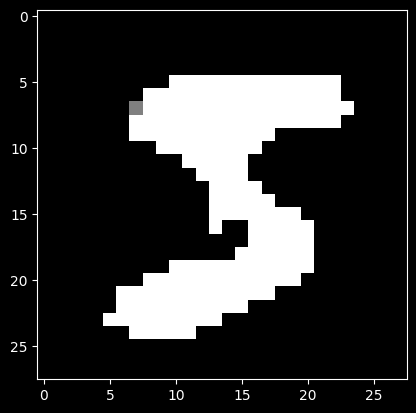

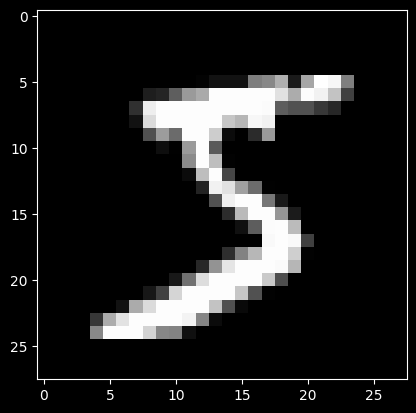

In [5]:
im0 = datasets.MNIST(root=test_root, train=True).data[0].float()
im1 = datasets.MNIST(root=test_root, train=True).data[1].float()
im2 = datasets.MNIST(root=test_root, train=True).data[2].float()
im0_reconstructed = to_im(net(im0)[0])
plt.figure()
plt.imshow(im0_reconstructed.reshape(28,28),cmap='gray')
plt.figure()
plt.imshow(im0.reshape(28,28),cmap='gray')

In [ ]:
# Create and save matrix A in feature space. (Very long, no need to re-run)

latent_size = 40;
A = np.zeros([40,60000])
for i in range(datasets.MNIST(root=test_root, train=True).data.size()[0]):
    current_img = datasets.MNIST(root=test_root, train=True).data[i].float();
    (mu, logvar) = net.encode(current_img.reshape(-1, 784));
    feature_vec = np.concatenate((mu[0].detach().numpy() ,logvar[0].detach().numpy()));
    A[:,i] = feature_vec
    if((i+1)%1000==0):
        print(i)
np.save("mnist_featureA_vae",A)
    

In [44]:
A = np.load('mnist_featureA_vae.npy')
b = im1 + np.random.randn()

In [45]:
np.linalg.norm(b)
b.size()

b_noisy = b + (0.03*np.linalg.norm(b))*torch.randn(28,28)

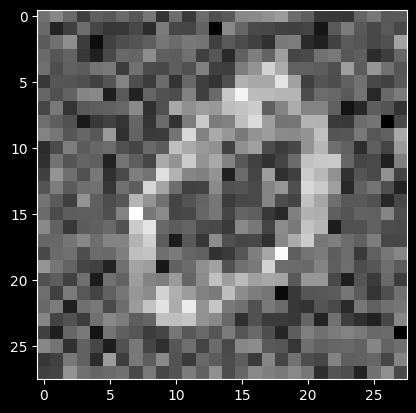

In [46]:
plt.imshow(b_noisy,cmap = 'gray')

In [47]:
A= np.array(A)
A = np.float64(A)

(mu, logvar) = net.encode(b_noisy.reshape(-1, 784));
target_b = np.concatenate((mu[0].detach().numpy() ,logvar[0].detach().numpy()));
target_b = np.float64(target_b)


In [48]:
kl = jl.KLLSModel(A,target_b)
jl.regularize(kl,10.0)

KL regularized least-squares
   m =         40  bNrm = 1.8e+03
   n =      60000  λ    = 1.0e+01
                   τ    = 1.0e+00


In [49]:
p = jl.solve(kl, logging=1,max_time= 300.0,max_iter = 2000)


KL regularized least-squares
   m =         40  bNrm = 1.8e+03
   n =      60000  λ    = 1.0e+01
                   τ    = 1.0e+00

Solver parameters:
   atol = 6.1e-06  max time (sec) =     300
   rtol = 6.1e-06  target ∥r∥<ε   = 1.1e-02

   iter   dual Obj    ∥∇dObj∥          Δ      Δₐ/Δₚ  cg its      cg msg
      0  -1.00e+00   9.48e+02    9.5e+01   0.0e+00       0             
      1  -2.16e+01   6.18e+02    9.5e+01   1.0e+00       8            ✓
      2  -3.12e+02   8.62e+02    9.5e+01   8.8e-01      24            ✓
      3  -3.12e+02   8.62e+02    4.0e+00  -4.2e-01       3            ✓
      4  -3.12e+02   8.62e+02    2.1e-01  -1.0e+00       1            ⊕
      5  -3.76e+02   1.10e+03    2.1e-01   3.5e-01       1            ⊕
      6  -4.10e+02   8.15e+02    2.1e-01   1.5e-01       1            ⊕
      7  -5.04e+02   8.35e+02    2.1e-01   5.4e-01       1            ⊕
      8  -5.67e+02   7.64e+02    2.1e-01   3.7e-01       1            ⊕
      9  -6.04e+02   1.07e+03    2.1e-0

In [50]:
test_out = A@(p.solution)
idea_new = test_out[0:20] + np.exp(0.5*test_out[20:40])
idea_new = np.float32(idea_new)

image_maybe = net.decode(torch.tensor(idea_new))

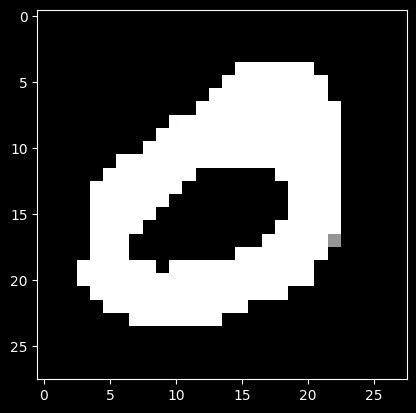

In [51]:
plot_img = image_maybe.detach().numpy()
plt.imshow(plot_img.reshape(28,28),cmap='gray');